# Preparing the launch file

In [1]:
import numpy as np
import pandas as pd


In [108]:
#pd.read_csv("./source-db/mp-160/POSCAR-unitcell")

pos_path = './source-db/mp-160/POSCAR-unitcell'
sample_path = './launch_thermal_si.py'
pos_file = open(pos_path,"r")

scaled_coordinates=open('./source-db/mp-160/scaled_coordinates.dat', "w")
linenumber=0
for line in pos_file.readlines():
    linenumber=linenumber+1
    if 3<=linenumber<=5:
        print("[",line,"],")


    if linenumber>=9:
        scaled_coordinates.write("("+line+"),\n")
    

scaled_coordinates.close()

[      4.8786175399999996    0.0000000000000000    0.0000000000000000
 ],
[     -2.4393087699999998    4.2250067299999996    0.0000000000000000
 ],
[      0.0000000000000000    0.0000000000000000   12.5104310900000009
 ],


# Parallel phono3py calculations using openMP

Togo-sensei found my phono3py in boston-lab did not use the parallel thread. I tried restalled phonopy and phono3py for several times, but didn' figure it out.

Today, after checking my .bashrc file line by line, I found the problem is caused my setting for the number of thread.

export OMP_NUM_THREADS = 1

After removing this line, and source .bashrc. The threads can be parallel.

## An example to get lattice thermal conductivity

be sure you have setup a virtual environment for aiida, and have a work job with its pk number (e.g. 186270 in my example)

In [ ]:
open verdi shell

In [ ]:
n3 = load_node(186270)

In [ ]:
n3.out.kappa

In [ ]:
<ArrayData: uuid: af240b4c-29ad-4c80-8691-a52a65d1587d (pk: 187185)>

In [ ]:
n3.out.kappa.get_arraynames()

In [ ]:
Out[4]:
[u'group_velocity',
 u'temperature',
 u'mesh',
 u'heat_capacity',
 u'frequency',
 u'gv_by_gv',
 u'gamma',
 u'weight',
 u'kappa',
 u'kappa_unit_conversion',
 u'qpoint',
 
 u'mode_kappa']

In [ ]:
f = n3.out.kappa

In [ ]:
f.get_array('kappa')[30] #this will print the ltc tensors

# output to json file example

In [3]:
import json
data = {
    'name': 'TiO2',
    'ID': 'mp-100',
    'ltc': [100,200]
}
json_str = json.dumps(data)

In [4]:
json_str

'{"name": "TiO2", "ID": "mp-100", "ltc": [100, 200]}'

In [ ]:
70325

<module 'json' from '/home/ywfang/miniconda3/envs/aiida/lib/python2.7/json/__init__.pyc'>

# A practical example

In [62]:
import json
try:
    from pymatgen.matproj.rest import MPRester #matproj.rest is moved to ext.matproj in new pymatgen versions
except ImportError: 
    from pymatgen.ext.matproj import MPRester
import os
data = {}
#structure_id is the ID of the structure in Materials Project


raster = MPRester(os.environ['PMG_MAPI_KEY'])
def basic_info_from_mp(structure_id):
    material_name = raster.query(structure_id,['pretty_formula'])
#    mg_structure = raster.get_structure_by_material_id(structure_id)
#    material_name = mg_structure.formula.replace('1', '').replace(' ', '')
    return(structure_id, material_name[0]['pretty_formula'])

data['compound'] = []
data['compound'].append({
    'structure_id': 'mp-149',
    'material_name': basic_info_from_mp('mp-149')[1]
})

with open('data.json', 'w') as outfile:
    json.dump(data, outfile)

In [63]:
%cat data.json

{"compound": [{"structure_id": "mp-149", "material_name": "Si"}]}

# load the requested data to thermaldata.json

In [60]:
import json
   
try:
    from pymatgen.matproj.rest import MPRester #matproj.rest is moved to ext.matproj in new pymatgen versions
except ImportError: 
    from pymatgen.ext.matproj import MPRester

import os
import pandas as pd

data = {}
#####################dict#####################################
#structure_id is the ID of the structure in Materials Project#
#ltc_cutoff (cutoff= 4, 5, 6... angstrom)                    #
#ltc (lattice thermal conductivity) unit: W/(m.k) at 300 K.  #
####################I/O file##################################
#finished-jobs.txt: it is a file contains the pk_number in my aiida calculations
#thermaldata.json: json files contaisn the lattice thermal conductivity data at 300 K

raster = MPRester(os.environ['PMG_MAPI_KEY'])
#PMG_MAPI_KEY should be set in .bashrc file or using command "export PMG_MAPI_KE = 'your key'"
def basic_info_from_mp(structure_id):
    material_name = raster.query(structure_id,['pretty_formula'])
    return(structure_id, material_name[0]['pretty_formula'])

job_df = pd.read_csv('./finished-jobs.txt')
structure_id_series = job_df['structure_id']
data['compound'] = []
index_in_job = 0
for i in job_df['structure_id'].tolist():
    data['compound'].append({
        'structure_id': i,
        'material_name': basic_info_from_mp(i)[1],
        'ltc4': job_df.iloc[index_in_job, 2],
        'ltc5': job_df.iloc[index_in_job, 3],
        'ltc6': job_df.iloc[index_in_job, 4],
        'ltc7': job_df.iloc[index_in_job, 5],
        'ltc8': job_df.iloc[index_in_job, 6],
        'ltc9': job_df.iloc[index_in_job, 7]
    })
    index_in_job = int(index_in_job) + 1

with open('thermaldata.json', 'w') as outfile:
    json.dump(data, outfile)

In [17]:
job_df

NameError: name 'job_df' is not defined

In [18]:
%cat finished-jobs.txt

structure_id,thermal_pk_no,ltc4, ltc5,ltc6,ltc7,ltc8, ltc9
mp-149, 197320, 8.18605044e+01, 7.90587211e+01
mp-463, 67170,7.31313422e+00, 7.25491292e+00, 7.28114961e+00
mp-286, 70325, 7.38043945e+00, 8.74758940e+00, 9.02450407e+00
mp-830, 72039, 3.35264611e+02, 3.58937448e+02, 3.68909175e+02, 3.72591003e+02, 3.72691752e+02
mp-22862, 91699, 6.44824175e+00, 6.40518782e+00, 6.43492759e+00
mp-1000, 85993, 7.14183088e+00, 7.28871012e+00, 7.28871012e+00
mp-422,  187245, 1.28146460e+02, 1.27259954e+02
mp-252, 187311, 1.75862373e+02, 1.75094956e+02
mp-971, 85957, 3.23210704e+00, 3.32267566e+00
mp-682, 86249, 2.10305474e+01, 2.11620852e+01, 2.12968932e+01, 2.12189553e+01, 2.12189553e+01
mp-1087, 87250, 8.20301065e+00, 8.70422798e+00, 8.90749802e+00, 9.14736050e+00, 9.09512637e+00, 9.10121918e+00
mp-2472, 87854, 7.79457197e+00, 8.33185233e+00, 8.66893035e+00, 8.65021488e+00, 8.66698540e+00 
mp-2605, 87992, 2.26551650e+01, 2.30388040e+01, 2.33735802e+01, 2.33195865e+01, 2.33583262e+01
mp-7140, 8846

In [66]:
%more thermaldata.json

# print the LTC for each computed materials

In [100]:
#read thermaldata.json and convert it to a DataFrame
import pandas as pd
from pandas import DataFrame
import json
with open('thermaldata.json', 'r') as outfile:
    newdata=json.load(outfile)['compound']
#df=DataFrame(newdata, index='material_name',columns=['ltc4','ltc5','ltc6','ltc7','ltc8'])
df=DataFrame(newdata)
df

,ltc4,ltc5,ltc6,ltc7,ltc8,ltc9,material_name,structure_id
0,81.860504,79.058721,NaN,NaN,NaN,NaN,Si,mp-149
1,7.313134,7.254913,7.281150,NaN,NaN,NaN,KF,mp-463
2,7.380439,8.747589,9.024504,NaN,NaN,NaN,YbSe,mp-286
3,335.264611,358.937448,368.909175,372.591003,372.691752,NaN,GaN,mp-830
4,6.448242,6.405188,6.434928,NaN,NaN,NaN,NaCl,mp-22862
5,7.141831,7.288710,7.288710,NaN,NaN,NaN,BaTe,mp-1000
6,128.146460,127.259954,NaN,NaN,NaN,NaN,BeS,mp-422
7,175.862373,175.094956,NaN,NaN,NaN,NaN,BeTe,mp-252
8,3.232107,3.322676,NaN,NaN,NaN,NaN,K2O,mp-971
9,21.030547,21.162085,21.296893,21.218955,21.218955,NaN,NaF,mp-682


In [101]:
df.set_index('material_name', inplace=True)
df

,ltc4,ltc5,ltc6,ltc7,ltc8,ltc9,structure_id
material_name,,,,,,,
Si,81.860504,79.058721,NaN,NaN,NaN,NaN,mp-149
KF,7.313134,7.254913,7.281150,NaN,NaN,NaN,mp-463
YbSe,7.380439,8.747589,9.024504,NaN,NaN,NaN,mp-286
GaN,335.264611,358.937448,368.909175,372.591003,372.691752,NaN,mp-830
NaCl,6.448242,6.405188,6.434928,NaN,NaN,NaN,mp-22862
BaTe,7.141831,7.288710,7.288710,NaN,NaN,NaN,mp-1000
BeS,128.146460,127.259954,NaN,NaN,NaN,NaN,mp-422
BeTe,175.862373,175.094956,NaN,NaN,NaN,NaN,mp-252
K2O,3.232107,3.322676,NaN,NaN,NaN,NaN,mp-971


In [98]:
#del df['structure_id']
GaN_data = pandas.Series(data = df.loc['GaN'][:5].values, index=np.arange(4,9,1))
print(GaN_data)
print(type(GaN_data))

4    335.265
5    358.937
6    368.909
7    372.591
8    372.692
dtype: object
<class 'pandas.core.series.Series'>


In [92]:
import pandas
s = pandas.Series(data = [1,2,3], index = ['A', 'B', 'C'])
s = s.reindex(index = ['B','A','C'])
s

B    2
A    1
C    3
dtype: int64

# LTC as a function of cutoff for GaN

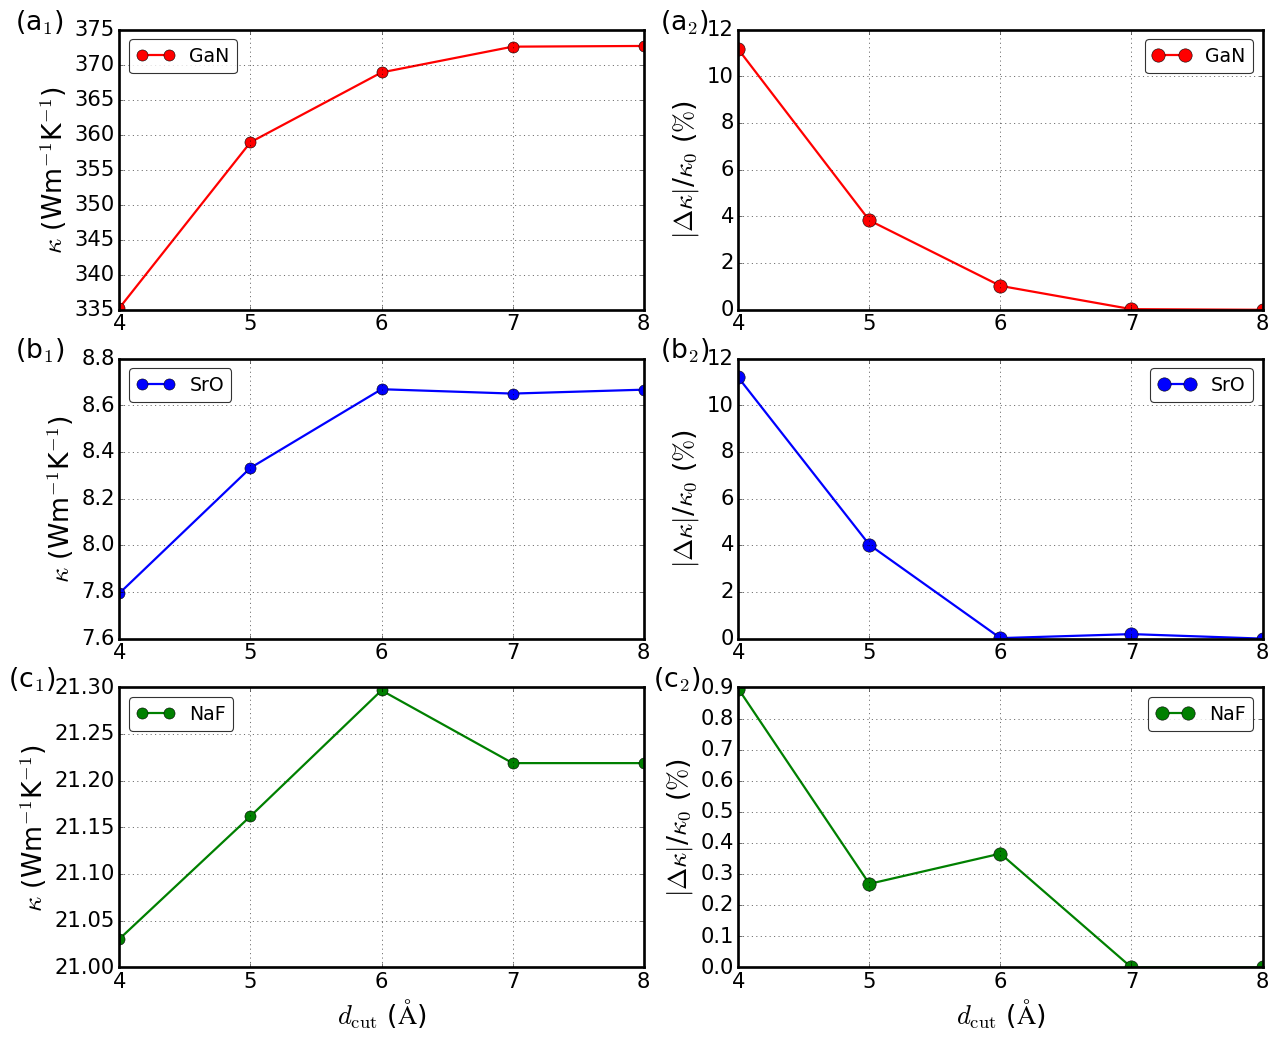

In [16]:
%matplotlib inline
# For the reference of the default color map of matplotlib, see
# https://matplotlib.org/users/dflt_style_changes.html
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = '1'
#if choose the grey backgroud, use 0.75
mpl.rcParams['figure.figsize'] = [16,13]
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.8
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['legend.scatterpoints'] = 1 #scatterpoints,
#it's the numer of maker points in the legend when
#creating a legend entry for a scatter plot
#mpl.rcParams['legend.markerscale']=0 #if we donnot want display the makrer, set to be 0
mpl.rcParams["axes.formatter.useoffset"]=False #turn off the axis offset-values.
# If on. the axis label will use a offset value by the side of axis
mpl.rcParams["axes.linewidth"]  = 2.4 #change the boarder width
#plt.rcParams["axes.edgecolor"] = "0.15" #change the boarder color

ticklabel_size = 19
mpl.rcParams['xtick.labelsize'] = ticklabel_size
mpl.rcParams['ytick.labelsize'] = ticklabel_size


import matplotlib.pyplot as plt
import numpy as np
import pandas
from pandas import DataFrame
import json

#import pdf module
from matplotlib.backends.backend_pdf import PdfPages


with open('thermaldata.json', 'r') as outfile:
    newdata=json.load(outfile)['compound']
df=DataFrame(newdata)
df.set_index('material_name', inplace=True) #use the column 'material_name' to replace the old index

GaN_data = pandas.Series(data = df.loc['GaN'][:5].values, index=np.arange(4,9,1))
SrO_data = pandas.Series(data = df.loc['SrO'][:5].values, index=np.arange(4,9,1))
NaF_data = pandas.Series(data = df.loc['NaF'][:5].values, index=np.arange(4,9,1))

fig1 = plt.figure()
ax1=fig1.add_subplot(3,2,1)
ax1.plot(GaN_data.index, GaN_data.values, 'ro-', markersize=10, label = 'GaN')
ax1.legend(loc="upper left")
plt.xticks(np.arange(4, 9, 1))
ax1.text(3.2, 375, '(a$_1$)', fontsize=24)
#ax1.set_xlabel(r'${d_\mathrm{cut}}$ (${\mathrm{\AA}}$)',fontsize=24)
ax1.set_ylabel(r'$\kappa$ (Wm$^{-1}$K$^{-1}$)', fontsize=24)
ax1.grid()
plt.tight_layout()

ax2=fig1.add_subplot(3,2,2)
ax2.plot(GaN_data.index, np.abs(GaN_data.values-GaN_data.values[-1])*100.0/GaN_data.values, 'ro-',
           markersize=12, label = 'GaN')
ax2.legend(loc="upper right")
plt.xticks(np.arange(4, 9, 1))
ax2.text(3.4, 12, '(a$_2$)', fontsize=24)
#ax2.set_xlabel(r'${d_\mathrm{cut}}$ (${\mathrm{\AA}}$)',fontsize=24)
ax2.set_ylabel('${|\Delta \kappa|}$/${\kappa_0}$ ($\%$)',fontsize=24)
ax2.grid()
plt.tight_layout()

ax3=fig1.add_subplot(3,2,3)
ax3.plot(SrO_data.index, SrO_data.values, 'bo-', markersize=10, label = 'SrO')
ax3.legend(loc="upper left")
plt.xticks(np.arange(4, 9, 1))
ax3.text(3.2, 8.8, '(b$_1$)', fontsize=24)
#ax3.set_xlabel(r'${d_\mathrm{cut}}$ (${\mathrm{\AA}}$)',fontsize=24)
ax3.set_ylabel(r'$\kappa$ (Wm$^{-1}$K$^{-1}$)', fontsize=24)
ax3.grid()
plt.tight_layout()

ax4=fig1.add_subplot(3,2,4)
ax4.plot(SrO_data.index, np.abs(SrO_data.values-SrO_data.values[-1])*100.0/SrO_data.values, 'bo-',
           markersize=12, label = 'SrO')
ax4.legend(loc="upper right")
plt.xticks(np.arange(4, 9, 1))
ax4.text(3.4, 12, '(b$_2$)', fontsize=24)
#ax4.set_xlabel(r'${d_\mathrm{cut}}$ (${\mathrm{\AA}}$)',fontsize=24)
ax4.set_ylabel('${|\Delta \kappa|}$/${\kappa_0}$ ($\%$)',fontsize=24)
ax4.grid()
plt.tight_layout()

ax5=fig1.add_subplot(3,2,5)
ax5.plot(NaF_data.index, NaF_data.values, 'go-', markersize=10, label = 'NaF')
ax5.legend(loc="upper left")
plt.xticks(np.arange(4, 9, 1))
ax5.text(3.15, 21.3, '(c$_1$)', fontsize=24)
ax5.set_xlabel(r'${d_\mathrm{cut}}$ (${\mathrm{\AA}}$)',fontsize=24)
ax5.set_ylabel(r'$\kappa$ (Wm$^{-1}$K$^{-1}$)', fontsize=24)
ax5.grid()
plt.tight_layout()

ax6=fig1.add_subplot(3,2,6)
ax6.plot(NaF_data.index, np.abs(NaF_data.values-NaF_data.values[-1])*100.0/NaF_data.values, 'go-',
           markersize=12, label = 'NaF')
ax6.legend(loc="upper right")
plt.xticks(np.arange(4, 9, 1))
ax6.text(3.35, 0.9, '(c$_2$)', fontsize=24)
ax6.set_xlabel(r'${d_\mathrm{cut}}$ (${\mathrm{\AA}}$)',fontsize=24)
ax6.set_ylabel('${|\Delta \kappa|}$/${\kappa_0}$ ($\%$)',fontsize=24)
ax6.grid()
#plt.gca().get_legend().remove() This will remove the legend all
plt.tight_layout()

pp1 = PdfPages('./LTC-GaN-SrO-NaF.pdf')
pp1.savefig(fig1)
pp1.close()

In [148]:
np.abs(1-2)

1

## Simple tutorial of Pandas plot 

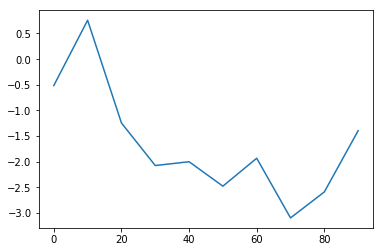

In [7]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np

s = Series(np.random.randn(10).cumsum(), index= np.arange(0,100,10))
s.plot()

In [8]:
s

0    -0.514082
10    0.758156
20   -1.242451
30   -2.072440
40   -1.998019
50   -2.474126
60   -1.929989
70   -3.092763
80   -2.586300
90   -1.393270
dtype: float64

In [35]:
job_df.iloc[0,2]

81.860504400000011

# Convergence criteria in lattice thermal conductivity calculations

In our code, criteria is achived by using "numpy.allclose" function. 
The usage of "numpy.allclose": numpy.allclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False). Here, a and b are numpy arrarys. The relative difference (rtol * abs(b)) and the absolute difference atol are added together to compare against the absolute difference between a and b.

Specifically in our thermal conductivity calculations, a and b are replaced with current kappa numpy.ndarray and previous kappa numpy.ndarray, respectively. rtol and atol are chosen to be 0.3 and 0.1 respectively. 

code segment:

is_converged = np.allclose(self.ctx.conductivity, self.ctx.prev_conductivity,
                                           rtol=float(self.inputs.rtol),
                                           atol=float(self.inputs.atol))

## References:

[1. Using iloc, loc, & ix to select rows and columns in Pandas DataFrames](https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)

[2. Phonon database at 2017-06-21](http://phonondb.mtl.kyoto-u.ac.jp/ph20170621/index.html)

[3. numpy.allclose at SciPy.org](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.allclose.html)

[4. Reading and Writing JSON to a File in Python](http://stackabuse.com/reading-and-writing-json-to-a-file-in-python/)